# demo_lenspyx

This notebook shows how to generate a lensed CMB maps using the curvedskylensing module

In [1]:
%matplotlib inline
import os
import pylab as pl
import lenspyx

In [2]:
if 'OMP_NUM_THREADS' in os.environ.keys():
    print('Calculation will be performed on %s openmp threads'%os.environ['OMP_NUM_THREADS'] )

In [3]:
# parameters which impact of the accuracy of the result (and the execution time):

lmax = 2048  # desired lmax of the lensed field.
dlmax = 1024  # lmax of the unlensed fields is lmax + dlmax.  (some buffer is required for accurate lensing at lmax)
nside = 2048 # The lensed tlm's are computed with healpy map2alm from a lensed map at resolution 'nside_lens'
facres = -1 # The lensed map of resolution is interpolated from a default high-res grid with about 0.7 amin-resolution
            # The resolution is multiplied by a factor 2 ** (-facres) if this is set.
            # (higher facres slows down computations and vice versa)
    
# lmax = 4096
# lmax=1024
# nside_lens=4096
# facres=0 
# is a choice of parameters that gives an lensed TT spectrum 1% accurate down to 4096.

In [4]:
# We first generate an unlensed temperature and lensing potential. 
# Here for simplicity we use healpy synalm, neglecting correlations between T, E and phi.

from lenspyx.utils import camb_clfile
import healpy as hp, numpy as np

cls_path = os.path.join(os.path.dirname(os.path.abspath(lenspyx.__file__)), 'data', 'cls')

cl_len = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))
cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))

tlm_unl = hp.synalm(cl_unl['tt'], lmax=lmax + dlmax, new=True)
plm = hp.synalm(cl_unl['pp'], lmax=lmax + dlmax, new=True)

# We then transform the lensing potential into spin-1 deflection field, and deflect the temperature map.
dlm = hp.almxfl(plm, np.sqrt(np.arange(lmax + 1, dtype=float) * np.arange(1, lmax + 2)))
Tlen  = lenspyx.alm2lenmap(tlm_unl, [dlm, None], nside, facres=facres)


 DUCC totalconvolve deflection instantiated 1e-07 1.5


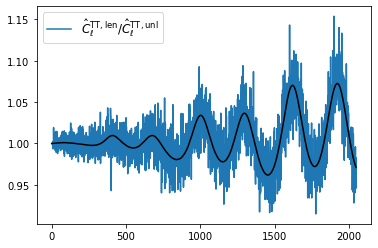

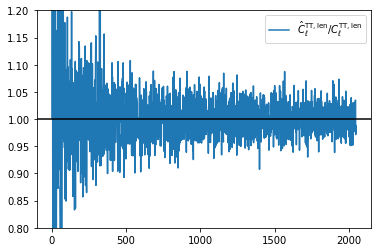

In [5]:
# Plot unlensed vs lensed spectrum.

ell = np.arange(1, lmax + 1, dtype=int)
cl_Tlen = hp.alm2cl(hp.map2alm(Tlen, lmax=lmax))
pl.plot(ell, cl_Tlen[ell] /hp.alm2cl(tlm_unl)[ell], 
        label=r'$\hat C_\ell^{\rm TT, len}/\hat C_\ell^{\rm TT, unl}$')
pl.legend(fontsize=12)
pl.plot(cl_len['tt'][ell] /cl_unl['tt'][ell], c='k', label='Prediction')

pl.figure()
pl.plot(ell, cl_Tlen[ell] /cl_len['tt'][ell], 
        label=r'$\hat C_\ell^{\rm TT, len}/ C_\ell^{\rm TT, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend()

In [6]:
#Now we show a similar example for polarization

elm_unl = hp.synalm(cl_unl['ee'], lmax=lmax + dlmax, new=True)
Qlen, Ulen  = lenspyx.alm2lenmap_spin([elm_unl, None], [dlm, None], nside, 2, facres=facres)
elm_len, blm_len = hp.map2alm_spin([Qlen, Ulen], 2, lmax=lmax)


 DUCC totalconvolve deflection instantiated 1e-07 1.5


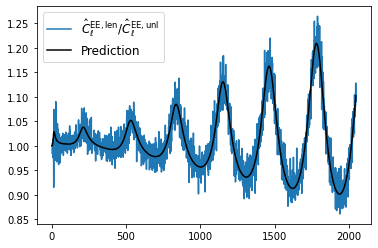

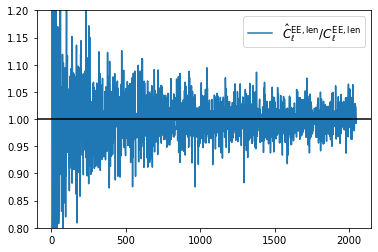

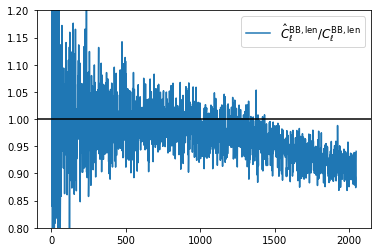

In [7]:
ell = np.arange(2, lmax + 1, dtype=int)
pl.plot(ell, hp.alm2cl(elm_len)[ell] /hp.alm2cl(elm_unl)[ell], label=r'$\hat C_\ell^{\rm EE, len}/\hat C_\ell^{\rm EE, unl}$')
pl.plot(cl_len['ee'][ell] /cl_unl['ee'][ell], c='k', label='Prediction')
pl.legend(fontsize=12)

pl.figure()
pl.plot(ell, hp.alm2cl(elm_len)[ell] /cl_len['ee'][ell], label=r'$\hat C_\ell^{\rm EE, len}/ C_\ell^{\rm EE, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend(fontsize=12)

pl.figure()
pl.plot(ell, hp.alm2cl(blm_len)[ell] /cl_len['bb'][ell], label=r'$\hat C_\ell^{\rm BB, len}/ C_\ell^{\rm BB, len}$')
pl.axhline(1., c='k')
pl.ylim(0.8, 1.2)
pl.legend(fontsize=12)

In [8]:
# Alternatively, we could have computed the position-space deflection and lensed all maps with it
# This saves on spin-1 transform execution time total.

Red, Imd = hp.alm2map_spin([dlm, np.zeros_like(dlm)], nside, 1, hp.Alm.getlmax(dlm.size))
Tlenv2  = lenspyx.alm2lenmap(tlm_unl, [Red, Imd], nside, facres=facres, verbose=False)
Qlenv2, Ulenv2  = lenspyx.alm2lenmap_spin([elm_unl, None], [Red, Imd], nside, 2, facres=facres, verbose=False)
assert np.all(Tlenv2 == Tlen)
assert np.all(Qlenv2 == Qlen)
assert np.all(Ulenv2 == Ulen)

 DUCC totalconvolve deflection instantiated 1e-07 1.5


RuntimeError: 
scarf/functions.h: 28 (unique_ptr<ducc0::detail_sharp::sharp_alm_info> set_triangular_alm_info(int64_t, int64_t)):

Assertion failure
negative mmax
